In [1]:
from torchvision import models
from image import load_image
import matplotlib.pyplot as plt
from deepdream.model import ModelWithActivations
from tqdm import tqdm
import numbers
import math

dream_model = ModelWithActivations(models.vgg16(pretrained=True))#models.googlenet(weights='DEFAULT'))

C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch
import numpy as np
import scipy.ndimage as nd

def prepare_input_image(input_image: np.ndarray):
    input_image = torch.from_numpy(input_image)
    input_image = torch.unsqueeze(input_image, 0) # minibatch
    input_image.requires_grad = True
    return input_image

In [3]:
from torchmetrics.functional import total_variation
def train_dream(dream_model, input_image, iterations=10, jitter=30):
    input_image.requires_grad = True
    size = input_image.shape[-2] * input_image.shape[-1]
    for iteration in tqdm(range(iterations)):
        out = dream_model(input_image)
        activations = dream_model.get_all_activations()[-1][:, [71, 208]]
#         print(activations[0, [1, 71, 208]])#[1, 71, 208]
        losses = [torch.linalg.vector_norm(activation, ord=2) for activation in activations]
        loss = torch.mean(torch.stack(losses))
        regularization = 100 * total_variation(input_image) / size
        print(loss, regularization)
        loss = loss - regularization #71
        loss.backward()
        grad = input_image.grad.data
#         grad = CascadeGaussianSmoothing(kernel_size=9, sigma=1.6)(grad)
        grad = 1.5 / torch.mean(torch.abs(grad)) * grad
        input_image.data += 0.1*grad
        input_image.grad.data.zero_()
        
    return input_image

In [4]:
image = load_image("examples/sky.jpg")
image = np.squeeze(image.numpy())

In [5]:
octaves = [image]
octave_n = 2
octave_scale = 1.4
n_iter = 7
for i in range(octave_n-1):
    octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))

detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
for octave, octave_base in enumerate(octaves[::-1]):
    h, w = octave_base.shape[-2:]
    if octave > 0:
        # upscale details from the previous octave
        h1, w1 = detail.shape[-2:]
        detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

    input_image = octave_base+detail
    
    jitter = 30
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    input_image = np.roll(np.roll(input_image, ox, -1), oy, -2) # apply jitter shift
    
    input_image_torch = torch.unsqueeze(torch.from_numpy(input_image), 0)
    input_image_torch = train_dream(dream_model, input_image_torch, n_iter)
    input_image = np.squeeze(input_image_torch.detach().numpy())
    
    input_image = np.roll(np.roll(input_image, -ox, -1), -oy, -2)
    detail = input_image-octave_base

  0%|                                                                                                                                                                                    | 0/7 [00:00<?, ?it/s]

tensor(0.2957, grad_fn=<MeanBackward0>) tensor(25.7844, grad_fn=<DivBackward0>)


 14%|████████████████████████▌                                                                                                                                                   | 1/7 [00:05<00:31,  5.24s/it]

tensor(0.4579, grad_fn=<MeanBackward0>) tensor(108.8402, grad_fn=<DivBackward0>)


 29%|█████████████████████████████████████████████████▏                                                                                                                          | 2/7 [00:09<00:24,  4.95s/it]

tensor(3.6653, grad_fn=<MeanBackward0>) tensor(112.1516, grad_fn=<DivBackward0>)


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                  | 3/7 [00:15<00:20,  5.11s/it]

tensor(9.1012, grad_fn=<MeanBackward0>) tensor(122.6902, grad_fn=<DivBackward0>)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 4/7 [00:20<00:15,  5.08s/it]

tensor(13.4248, grad_fn=<MeanBackward0>) tensor(135.1899, grad_fn=<DivBackward0>)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 5/7 [00:25<00:10,  5.05s/it]

tensor(16.5701, grad_fn=<MeanBackward0>) tensor(148.0071, grad_fn=<DivBackward0>)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 6/7 [00:30<00:05,  5.03s/it]

tensor(22.9387, grad_fn=<MeanBackward0>) tensor(160.8531, grad_fn=<DivBackward0>)


  0%|                                                                                                                                                                                    | 0/7 [00:00<?, ?it/s]

tensor(10.1013, grad_fn=<MeanBackward0>) tensor(92.2862, grad_fn=<DivBackward0>)


 14%|████████████████████████▌                                                                                                                                                   | 1/7 [00:09<00:57,  9.65s/it]

tensor(18.0768, grad_fn=<MeanBackward0>) tensor(136.7897, grad_fn=<DivBackward0>)


 29%|█████████████████████████████████████████████████▏                                                                                                                          | 2/7 [00:19<00:48,  9.72s/it]

tensor(29.0804, grad_fn=<MeanBackward0>) tensor(156.5711, grad_fn=<DivBackward0>)


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                  | 3/7 [00:28<00:37,  9.49s/it]

tensor(39.9380, grad_fn=<MeanBackward0>) tensor(175.1028, grad_fn=<DivBackward0>)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 4/7 [00:37<00:27,  9.26s/it]

tensor(51.5757, grad_fn=<MeanBackward0>) tensor(190.0510, grad_fn=<DivBackward0>)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 5/7 [00:47<00:18,  9.34s/it]

tensor(67.1385, grad_fn=<MeanBackward0>) tensor(203.3629, grad_fn=<DivBackward0>)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 6/7 [00:55<00:09,  9.16s/it]

tensor(91.3705, grad_fn=<MeanBackward0>) tensor(213.9304, grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:04<00:00,  9.21s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


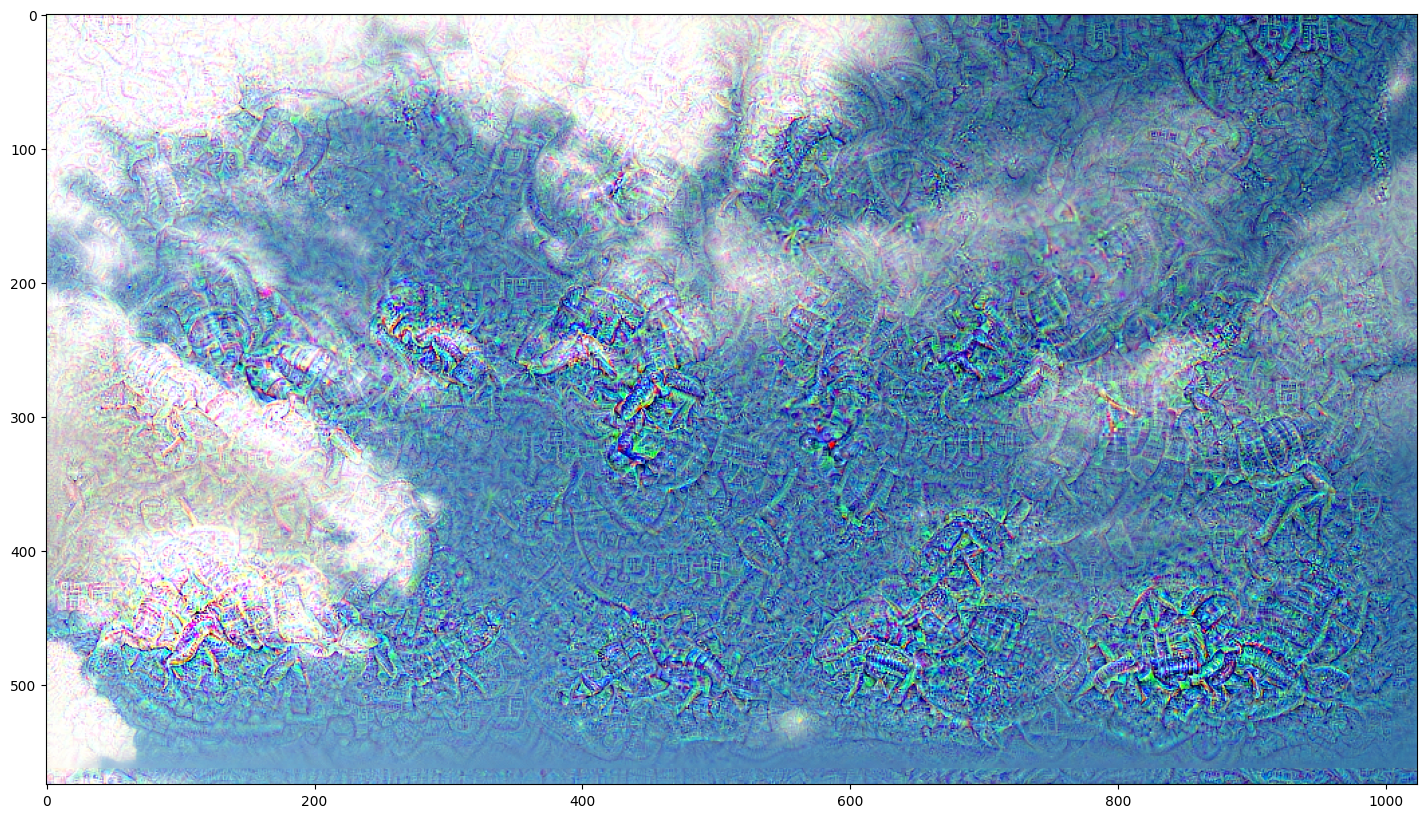

In [7]:
def deprocess(image):
    img = image.copy()
    img[0, :, :] *= 0.229
    img[1, :, :] *= 0.224
    img[2, :, :] *= 0.225
    img[0, :, :] += 0.485
    img[1, :, :] += 0.456
    img[2, :, :] += 0.406
    return img

plt.figure(figsize=(20, 10))
img = np.moveaxis(deprocess(input_image), 0, -1)
plt.imshow(img)